In [1]:
!pip install kagglehub

In [2]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 4.1 MB/s eta 0:00:00


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("patelris/crop-yield-prediction-dataset")

print("Path to dataset files:", path)

100%|██████████| 959k/959k [00:00<00:00, 20.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/patelris/crop-yield-prediction-dataset/versions/1


In [4]:
import pandas as pd
import os

# Construct the full path to the CSV file
csv_file_path_new = os.path.join(path, "yield.csv") # Changed file name here

# Load the dataset
df_new = pd.read_csv(csv_file_path_new)

print("Dataset Head:")
print(df_new.head())
print("\nDataset Dimensions (rows, columns):")
print(df_new.shape)
print("\nDataset Information:")
df_new.info()

Dataset Head:
  Domain Code Domain  Area Code         Area  Element Code Element  Item Code  \
0          QC  Crops          2  Afghanistan          5419   Yield         56   
1          QC  Crops          2  Afghanistan          5419   Yield         56   
2          QC  Crops          2  Afghanistan          5419   Yield         56   
3          QC  Crops          2  Afghanistan          5419   Yield         56   
4          QC  Crops          2  Afghanistan          5419   Yield         56   

    Item  Year Code  Year   Unit  Value  
0  Maize       1961  1961  hg/ha  14000  
1  Maize       1962  1962  hg/ha  14000  
2  Maize       1963  1963  hg/ha  14260  
3  Maize       1964  1964  hg/ha  14257  
4  Maize       1965  1965  hg/ha  14400  

Dataset Dimensions (rows, columns):
(56717, 12)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56717 entries, 0 to 56716
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        ------

In [5]:
import pandas as pd
import os

# List of CSV files identified in the dataset directory
csv_files = ['temp.csv', 'pesticides.csv', 'yield_df.csv', 'yield.csv', 'rainfall.csv']

for file_name in csv_files:
    full_path = os.path.join(path, file_name)
    print(f"\n--- Details for {file_name} ---")
    try:
        df_current = pd.read_csv(full_path)
        print("Dataset Head:")
        print(df_current.head())
        print("\nDataset Dimensions (rows, columns):")
        print(df_current.shape)
        print("\nDataset Information:")
        df_current.info()
    except Exception as e:
        print(f"Error loading {file_name}: {e}")


--- Details for temp.csv ---
Dataset Head:
   year        country  avg_temp
0  1849  Côte D'Ivoire     25.58
1  1850  Côte D'Ivoire     25.52
2  1851  Côte D'Ivoire     25.67
3  1852  Côte D'Ivoire       NaN
4  1853  Côte D'Ivoire       NaN

Dataset Dimensions (rows, columns):
(71311, 3)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71311 entries, 0 to 71310
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      71311 non-null  int64  
 1   country   71311 non-null  object 
 2   avg_temp  68764 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB

--- Details for pesticides.csv ---
Dataset Head:
           Domain     Area Element                Item  Year  \
0  Pesticides Use  Albania     Use  Pesticides (total)  1990   
1  Pesticides Use  Albania     Use  Pesticides (total)  1991   
2  Pesticides Use  Albania     Use  Pesticides (total)  1992   
3  Pesticides Use

In [6]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings("ignore")

# Modeling imports
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import f_oneway, pearsonr

# Optional target encoder
try:
    from category_encoders import TargetEncoder
    HAS_TE = True
except Exception:
    HAS_TE = False

# ----------------------
# Config
# ----------------------
DATA_PATH = Path(path) / "yield_df.csv"   # <- change path if needed
ART_DIR = Path("./artifacts")
PLOTS_DIR = ART_DIR / "plots"
ART_DIR.mkdir(exist_ok=True, parents=True)
PLOTS_DIR.mkdir(exist_ok=True, parents=True)
RANDOM_STATE = 42

# ----------------------
# Utilities
# ----------------------
def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred))
    mask = denom != 0
    out = np.zeros_like(y_true, dtype=float)
    out[mask] = 2.0 * np.abs(y_true[mask] - y_pred[mask]) / denom[mask]
    return 100.0 * np.mean(out[mask]) if mask.any() else np.nan

def save_fig(fig, name):
    path = PLOTS_DIR / name
    fig.savefig(path, bbox_inches="tight", dpi=140)
    plt.close(fig)
    return path

# ----------------------
# 1) Load data
# ----------------------
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Cannot find {DATA_PATH}. Put yield_df.csv next to this script or change DATA_PATH.")

df = pd.read_csv(DATA_PATH)

# inspect recommended columns
expected = ["Area", "Item", "Year", "hg/ha_yield", "average_rain_fall_mm_per_year", "pesticides_tonnes", "avg_temp"]
print("Columns present:", [c for c in expected if c in df.columns])

# ----------------------
# 2) Clean & basic FE
# ----------------------
# Keep only needed cols (if available)
cols_keep = [c for c in expected if c in df.columns]
df = df[cols_keep].copy()

# Rename friendly
df = df.rename(columns={
    "Item": "Crop",
    "hg/ha_yield": "hg_ha_yield",
    "average_rain_fall_mm_per_year": "rain_mm",
    "pesticides_tonnes": "pesticides_tonnes",
    "avg_temp": "avg_temp",
})

# Convert Year to int
df["Year"] = pd.to_numeric(df["Year"], errors="coerce").astype("Int64")

# Convert yield to t/ha (hg/ha -> t/ha by dividing by 100)
df["Yield_tpha"] = pd.to_numeric(df["hg_ha_yield"], errors="coerce") / 100.0

# Numerics
for c in ["rain_mm", "pesticides_tonnes", "avg_temp"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Drop rows missing target or year or crop
df = df.dropna(subset=["Yield_tpha", "Year", "Crop"])

# Remove zero or negative area? If Area is country name here; keep Area (country) as categorical.
# (If your dataset uses 'Area' as country, we treat it as categorical)
if "Area" in df.columns:
    if pd.api.types.is_numeric_dtype(df["Area"]):
        df = df[df["Area"] > 0]

# Quick stats
print("Dataset size:", df.shape)
print("Year range:", int(df["Year"].min()), "to", int(df["Year"].max()))
print("Unique crops:", df["Crop"].nunique())

# ----------------------
# 3) Hypothesis tests & Correlations
# ----------------------
# ANOVA: top 10 crops
top_crops = df["Crop"].value_counts().index[:10].tolist()
groups = [df[df["Crop"] == c]["Yield_tpha"].dropna() for c in top_crops]
anova_stat, anova_p = f_oneway(*groups)
print(f"\nANOVA across top 10 crops: F = {anova_stat:.3f}, p = {anova_p:.3g}")

# Pearson correlations with yield (for available env columns)
corrs = {}
for col in ["rain_mm", "avg_temp", "pesticides_tonnes"]:
    if col in df.columns:
        mask = df[[col, "Yield_tpha"]].dropna()
        if len(mask) > 5:
            r, p = pearsonr(mask[col], mask["Yield_tpha"])
            corrs[col] = (r, p)
print("\nPearson correlations (col -> (r, p)):", corrs)

# ----------------------
# 4) Feature engineering
# ----------------------
# Choose features
FEATURES = []
if "rain_mm" in df.columns: FEATURES.append("rain_mm")
if "avg_temp" in df.columns: FEATURES.append("avg_temp")
if "pesticides_tonnes" in df.columns: FEATURES.append("pesticides_tonnes")
# Year and Crop and Area (country) included
FEATURES += ["Year", "Crop", "Area"]  # treat Area as categorical (country)

# Replace missing numeric values (we'll impute in pipeline)
# Keep a copy for later grouping evaluations
df = df.reset_index(drop=True)

# ----------------------
# 5) Train-test split (time-aware)
# ----------------------
# Use last 20% years as test
years_sorted = np.sort(df["Year"].unique())
cut_index = int(np.ceil(len(years_sorted) * 0.8))
train_years = years_sorted[:cut_index]
test_years = years_sorted[cut_index:]

train = df[df["Year"].isin(train_years)].copy()
test = df[df["Year"].isin(test_years)].copy()

# fallback if years split creates empty test (small dataset)
if test.shape[0] < 200:
    # fallback to random 80/20 split
    train, test = train_test_split(df, test_size=0.20, random_state=RANDOM_STATE)

print("\nTrain / Test sizes:", train.shape, test.shape)
print("Train years:", sorted(train["Year"].unique())[:3], "...", sorted(train["Year"].unique())[-3:])
print("Test years:", sorted(test["Year"].unique())[:3], "...", sorted(test["Year"].unique())[-3:])

# ----------------------
# 6) Preprocessing & pipelines
# ----------------------
# Numeric columns (present in FEATURES)
num_cols = [c for c in ["rain_mm", "avg_temp", "pesticides_tonnes", "Year"] if c in FEATURES]
cat_cols = [c for c in ["Crop", "Area"] if c in FEATURES]

# Preprocessor A: ordinal encode + numeric scaler
preproc_A = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("oe", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))]), cat_cols),
], remainder="drop")

# Preprocessor B: target encode Crop (if available) + encode Area
if HAS_TE:
    preproc_B = ColumnTransformer([
        ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), num_cols),
        ("crop_te", TargetEncoder(cols=["Crop"]), ["Crop"]),
        ("area_ord", Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("oe", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))]), ["Area"])
    ], remainder="drop")
else:
    preproc_B = preproc_A

# Models
gbm = HistGradientBoostingRegressor(learning_rate=0.05, max_iter=400, random_state=RANDOM_STATE)
ridge = Ridge(alpha=1.0, random_state=RANDOM_STATE)

pipe_gbm = Pipeline([("pre", preproc_B), ("model", gbm)])
pipe_ridge = Pipeline([("pre", preproc_A), ("model", ridge)])

# Train on log1p(yield)
y_tr = np.log1p(train["Yield_tpha"])
X_tr = train[FEATURES]
X_te = test[FEATURES]
y_te_true = test["Yield_tpha"].values  # in t/ha

print("\nTraining GBM pipeline...")
pipe_gbm.fit(X_tr, y_tr)
print("Training Ridge baseline...")
pipe_ridge.fit(X_tr, y_tr)

# ----------------------
# 7) Evaluation
# ----------------------
def evaluate(pipe, X_test, y_true_tpha):
    pred_log = pipe.predict(X_test)               # predicted log1p(yield)
    pred_yield = np.expm1(pred_log)              # back to t/ha
    # Calculate RMSE by taking the square root of MSE
    rmse = np.sqrt(mean_squared_error(y_true_tpha, pred_yield))
    mae = mean_absolute_error(y_true_tpha, pred_yield)
    r2 = r2_score(y_true_tpha, pred_yield)
    sm = smape(y_true_tpha, pred_yield)
    return {"RMSE_tpha": rmse, "MAE_tpha": mae, "R2": r2, "SMAPE%": sm, "pred_yield": pred_yield}

res_gbm = evaluate(pipe_gbm, X_te, y_te_true)
res_ridge = evaluate(pipe_ridge, X_te, y_te_true)

print("\nGBM Results (test):")
for k,v in res_gbm.items():
    if k != "pred_yield":
        print(f"  {k}: {v}")
print("\nRidge Results (test):")
for k,v in res_ridge.items():
    if k != "pred_yield":
        print(f"  {k}: {v}")

# Save model
joblib.dump(pipe_gbm, ART_DIR / "pipe_gbm.joblib")

# ----------------------
# 8) Diagnostics & plots
# ----------------------
pred_yield = res_gbm["pred_yield"]
# add to test frame for analysis
test = test.reset_index(drop=True)
test["Pred_Yield_tpha"] = pred_yield
test["Residual_tpha"] = test["Yield_tpha"] - test["Pred_Yield_tpha"]

# Plot 1: Predicted vs Actual
fig = plt.figure(figsize=(6,5))
plt.scatter(test["Yield_tpha"], test["Pred_Yield_tpha"], s=8, alpha=0.6)
plt.plot([test["Yield_tpha"].min(), test["Yield_tpha"].max()],
         [test["Yield_tpha"].min(), test["Yield_tpha"].max()],
         color="red", linewidth=1)
plt.xlabel("Actual Yield (t/ha)")
plt.ylabel("Predicted Yield (t/ha)")
plt.title("Predicted vs Actual Yield (GBM)")
p1 = save_fig(fig, "pred_vs_actual_yield.png")
print("Saved:", p1)

# Plot 2: Residual histogram
fig = plt.figure(figsize=(6,4))
plt.hist(test["Residual_tpha"].dropna(), bins=60)
plt.xlabel("Residual (Actual - Pred) t/ha")
plt.title("Residuals")
p2 = save_fig(fig, "residuals_hist.png")
print("Saved:", p2)

# Plot 3: Yield distribution (actual vs predicted)
fig = plt.figure(figsize=(6,4))
plt.hist(test["Yield_tpha"].dropna(), bins=50, alpha=0.6, label="Actual")
plt.hist(test["Pred_Yield_tpha"].dropna(), bins=50, alpha=0.6, label="Predicted")
plt.xlabel("Yield (t/ha)")
plt.legend()
plt.title("Yield Distribution: Actual vs Predicted")
p3 = save_fig(fig, "yield_distribution_compare.png")
print("Saved:", p3)

# Plot 4: Error by crop (top 15 crops)
top = test["Crop"].value_counts().index[:15]
crop_err = test[test["Crop"].isin(top)].groupby("Crop").apply(
    lambda g: np.sqrt(mean_squared_error(g["Yield_tpha"], g["Pred_Yield_tpha"])))
fig = plt.figure(figsize=(10,5))
crop_err.sort_values(ascending=False).plot(kind="bar")
plt.ylabel("RMSE (t/ha)")
plt.title("RMSE by Crop (top 15)")
p4 = save_fig(fig, "rmse_by_crop_top15.png")
print("Saved:", p4)

Columns present: ['Area', 'Item', 'Year', 'hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']
Dataset size: (28242, 8)
Year range: 1990 to 2013
Unique crops: 10

ANOVA across top 10 crops: F = 4881.447, p = 0

Pearson correlations (col -> (r, p)): {'rain_mm': (np.float64(0.0009621544715999047), np.float64(0.8715528403025214)), 'avg_temp': (np.float64(-0.1147769595912115), np.float64(1.9683060804577625e-83)), 'pesticides_tonnes': (np.float64(0.06408508765267704), np.float64(4.263424224636997e-27))}

Train / Test sizes: (23233, 8) (5009, 8)
Train years: [np.int64(1990), np.int64(1991), np.int64(1992)] ... [np.int64(2007), np.int64(2008), np.int64(2009)]
Test years: [np.int64(2010), np.int64(2011), np.int64(2012)] ... [np.int64(2011), np.int64(2012), np.int64(2013)]

Training GBM pipeline...
Training Ridge baseline...

GBM Results (test):
  RMSE_tpha: 252.55840186054007
  MAE_tpha: 137.76415263751537
  R2: 0.9301038369097225
  SMAPE%: 19.02530662480263

Ridge 

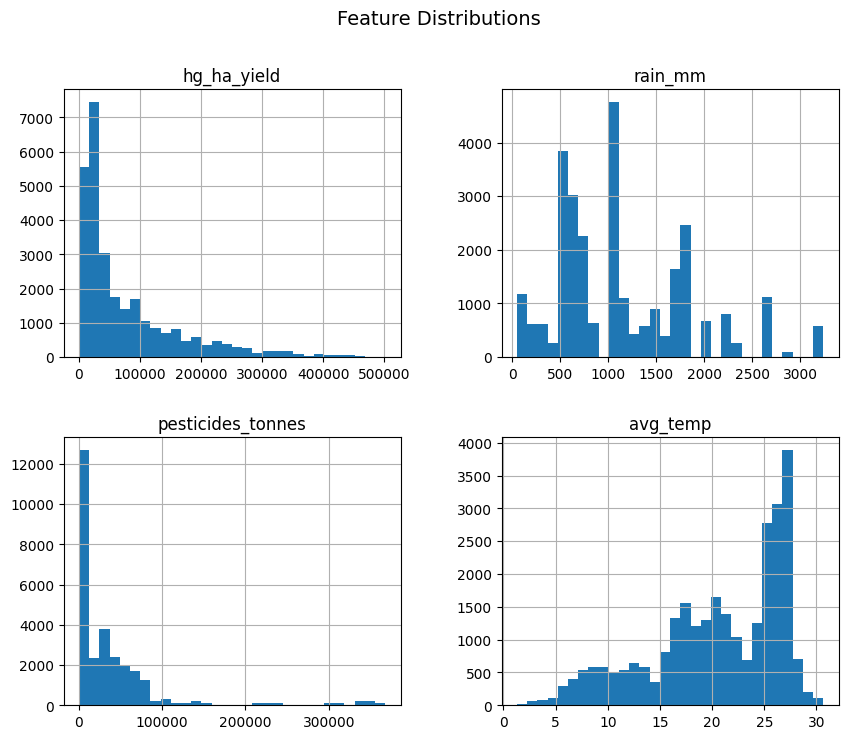

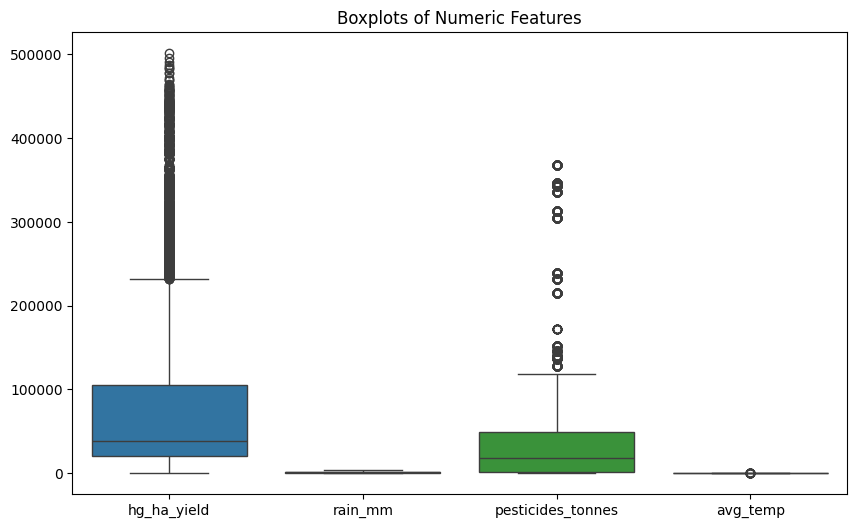

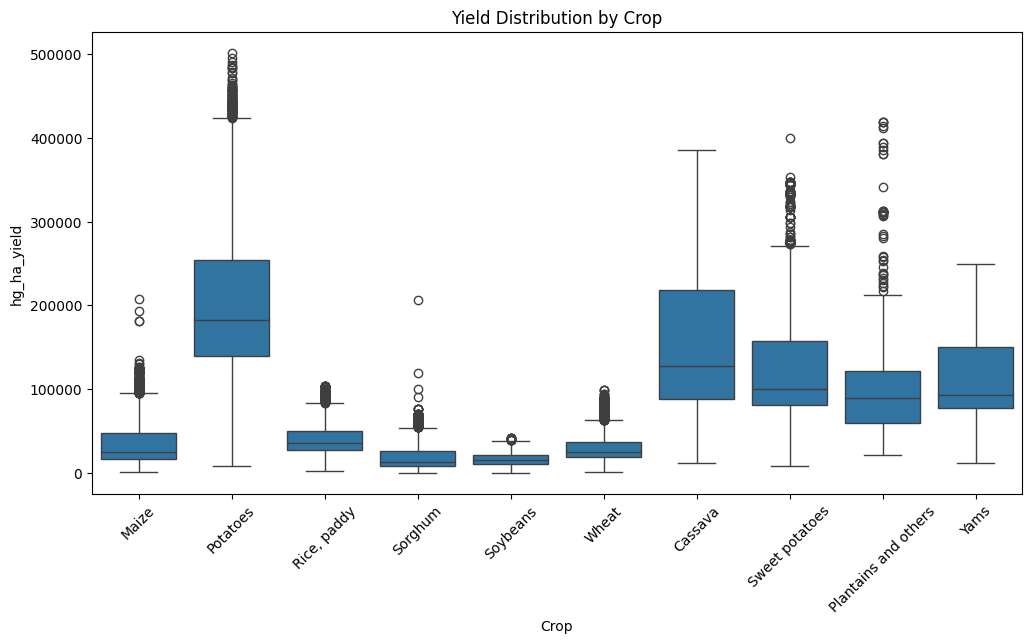

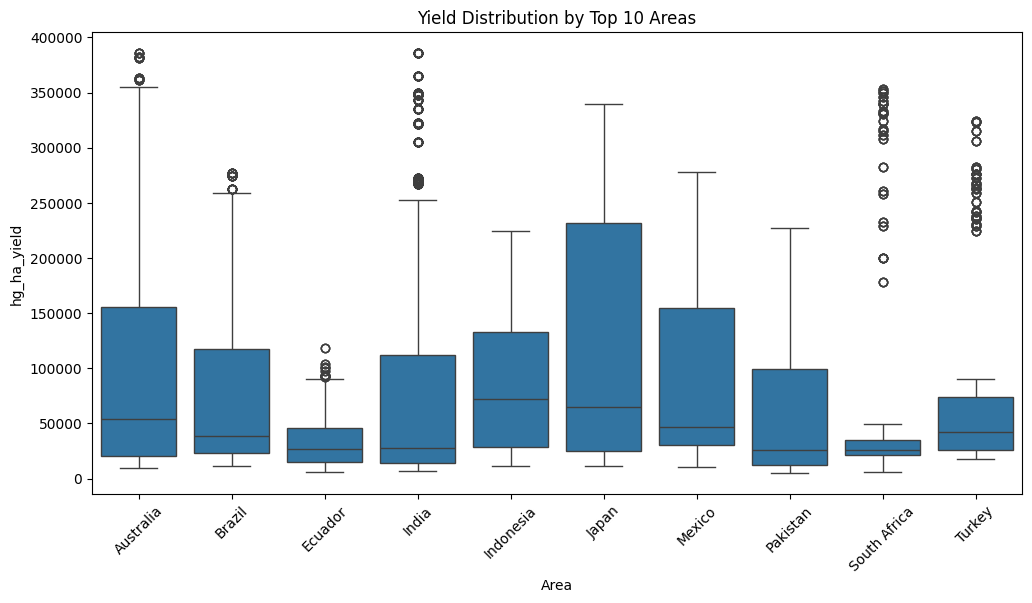

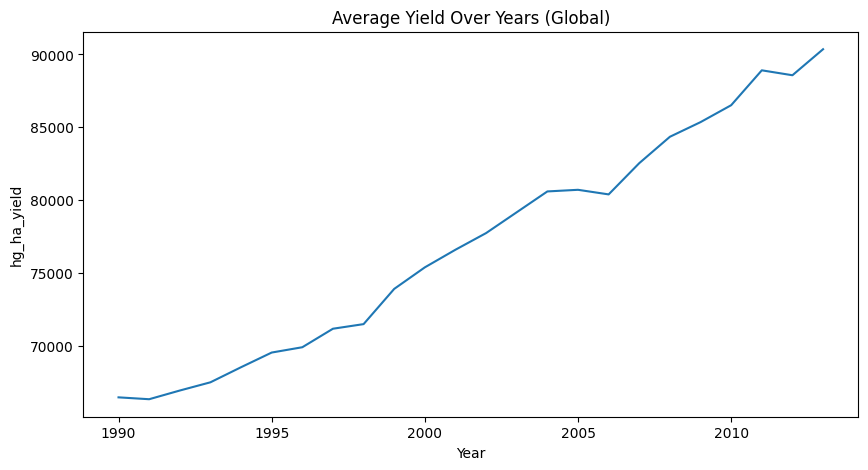

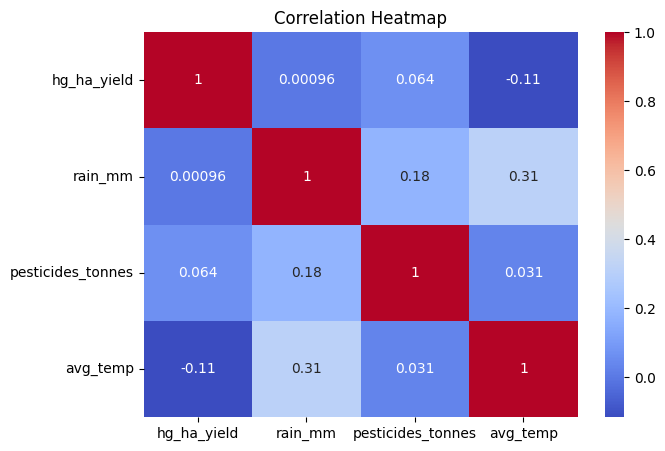

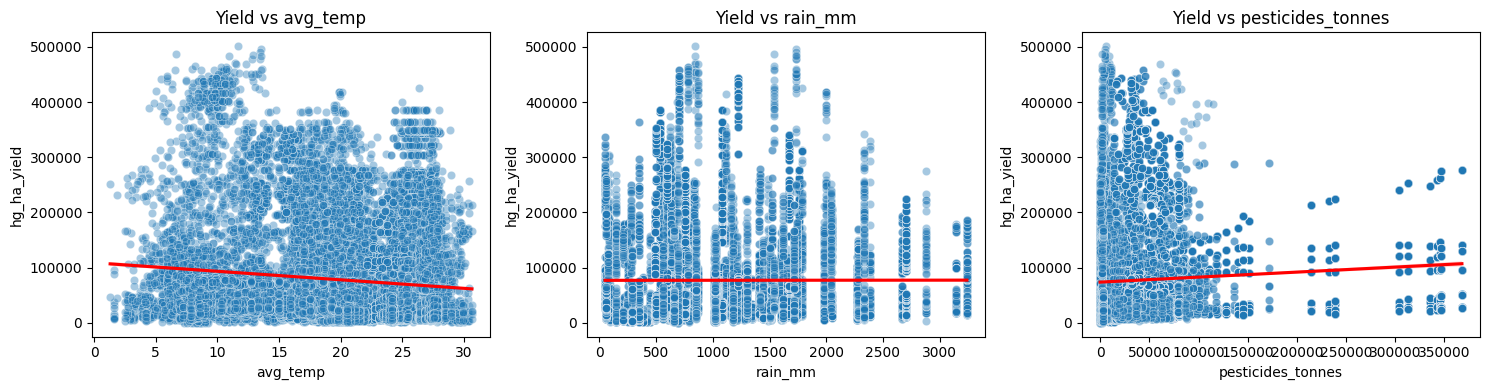

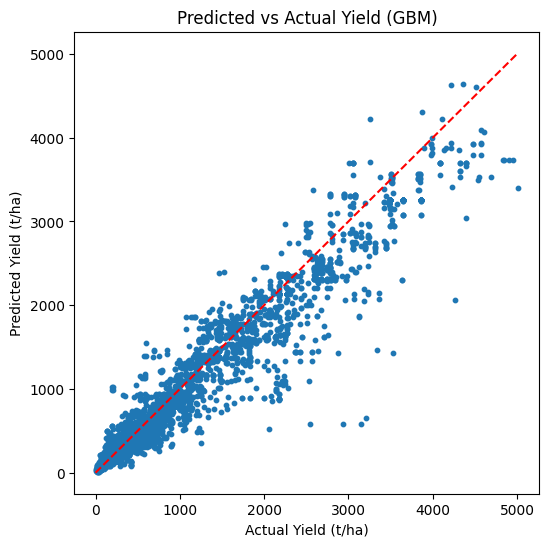

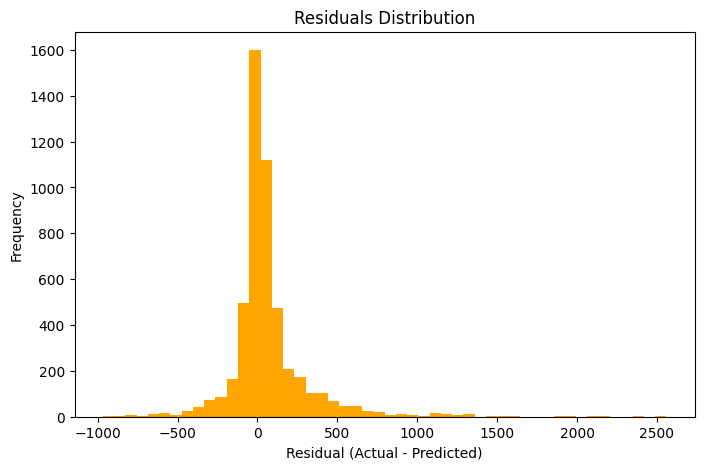

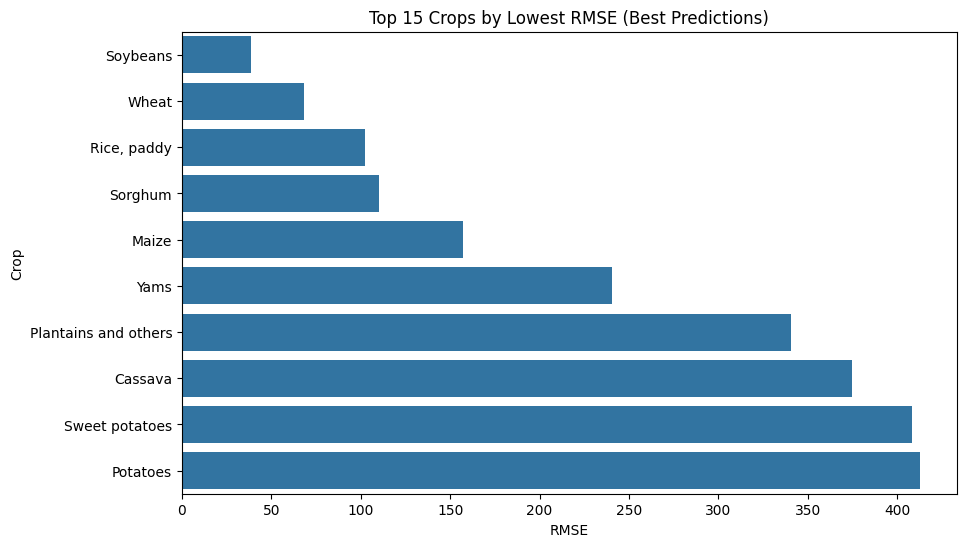

Feature importances not available for this model or sklearn version: 'HistGradientBoostingRegressor' object has no attribute 'feature_importances_'
Partial dependence plot failed: can't multiply sequence by non-int of type 'float'


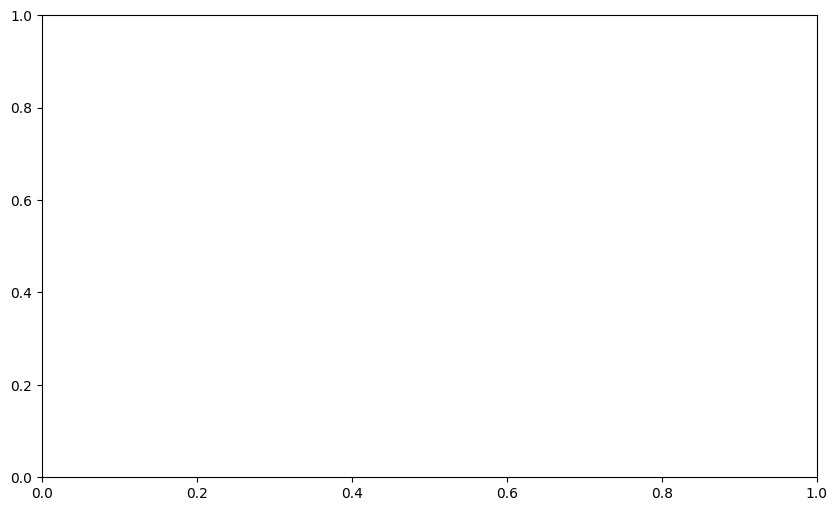

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

# ========== BASIC DATA DISTRIBUTIONS ==========

# Use the renamed columns from the previous step
num_cols = ["hg_ha_yield", "rain_mm", "pesticides_tonnes", "avg_temp"]

# Histograms
df[num_cols].hist(bins=30, figsize=(10,8))
plt.suptitle("Feature Distributions", fontsize=14)
plt.show()

# Boxplots for each numeric feature
plt.figure(figsize=(10,6))
sns.boxplot(data=df[num_cols])
plt.title("Boxplots of Numeric Features")
plt.show()

# Yield by Crop
plt.figure(figsize=(12,6))
sns.boxplot(x="Crop", y="hg_ha_yield", data=df) # Updated 'Item' to 'Crop' and 'hg/ha_yield' to 'hg_ha_yield'
plt.xticks(rotation=45)
plt.title("Yield Distribution by Crop")
plt.show()

# Yield by Country/Area
top_areas = df["Area"].value_counts().head(10).index
plt.figure(figsize=(12,6))
sns.boxplot(x="Area", y="hg_ha_yield", data=df[df["Area"].isin(top_areas)]) # Updated 'hg/ha_yield' to 'hg_ha_yield'
plt.xticks(rotation=45)
plt.title("Yield Distribution by Top 10 Areas")
plt.show()

# Trend over Years
plt.figure(figsize=(10,5))
sns.lineplot(x="Year", y="hg_ha_yield", data=df, estimator="mean", errorbar=None) # Updated 'hg/ha_yield' to 'hg_ha_yield', changed 'ci' to 'errorbar'
plt.title("Average Yield Over Years (Global)")
plt.show()

# ========== CORRELATIONS ==========
plt.figure(figsize=(7,5))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# ========== SCATTER RELATIONSHIPS ==========
plt.figure(figsize=(15,4))
for i, col in enumerate(["avg_temp", "rain_mm", "pesticides_tonnes"], 1): # Updated 'average_rain_fall_mm_per_year' to 'rain_mm'
    plt.subplot(1,3,i)
    sns.scatterplot(x=col, y="hg_ha_yield", data=df, alpha=0.4) # Updated 'hg/ha_yield' to 'hg_ha_yield'
    sns.regplot(x=col, y="hg_ha_yield", data=df, scatter=False, color="red") # Updated 'hg/ha_yield' to 'hg_ha_yield'
    plt.title(f"Yield vs {col}")
plt.tight_layout()
plt.show()

# ========== MODEL VISUALS ==========

# For these plots, we need the `test` DataFrame and `pipe_gbm` (which was 'best_pipe' in original snippet)
# Note: `test_df` and `best_pipe` are not defined in the current scope.
#       Using `test` and `pipe_gbm` from the previous cell's execution.

# 1) Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(test["Yield_tpha"], np.expm1(pipe_gbm.predict(X_te)), s=10) # Using 'test' df and 'Yield_tpha', 'pipe_gbm' and 'X_te'
plt.plot([0, max(test["Yield_tpha"])], [0, max(test["Yield_tpha"])], 'r--') # Using 'test' df and 'Yield_tpha'
plt.xlabel("Actual Yield (t/ha)")
plt.ylabel("Predicted Yield (t/ha)")
plt.title("Predicted vs Actual Yield (GBM)")
plt.show()

# 2) Residuals
residuals = test["Yield_tpha"] - np.expm1(pipe_gbm.predict(X_te)) # Using 'test' df and 'Yield_tpha', 'pipe_gbm' and 'X_te'
plt.figure(figsize=(8,5))
plt.hist(residuals, bins=50, color='orange')
plt.title("Residuals Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()

# 3) RMSE by Crop
from sklearn.metrics import mean_squared_error
crop_rmse = []
for crop in df["Crop"].unique(): # Updated 'Item' to 'Crop'
    sub = test[test["Crop"]==crop] # Using 'test' df and 'Crop'
    if len(sub)>5:
        pred = np.expm1(pipe_gbm.predict(sub[X_te.columns])) # Using 'pipe_gbm' and 'X_te.columns'
        rmse = np.sqrt(mean_squared_error(sub["Yield_tpha"], pred)) # Using 'Yield_tpha'
        crop_rmse.append((crop, rmse))
crop_rmse = pd.DataFrame(crop_rmse, columns=["Crop","RMSE"]).sort_values("RMSE")
plt.figure(figsize=(10,6))
sns.barplot(x="RMSE", y="Crop", data=crop_rmse.head(15))
plt.title("Top 15 Crops by Lowest RMSE (Best Predictions)")
plt.show()

# 4) Feature Importance
try:
    feat_imp = pipe_gbm.named_steps["model"].feature_importances_
    feat_names = pipe_gbm.named_steps["pre"].get_feature_names_out()
    fi = pd.DataFrame({"Feature": feat_names, "Importance": feat_imp}).sort_values("Importance", ascending=False)
    plt.figure(figsize=(8,6))
    sns.barplot(x="Importance", y="Feature", data=fi)
    plt.title("Feature Importances (GBM)")
    plt.show()
except Exception as e:
    print(f"Feature importances not available for this model or sklearn version: {e}")

# 5) Partial Dependence Plots
# Note: The indices for features_to_plot should correspond to the processed feature names.
#       The 'pre' step in `pipe_gbm` creates these. Let's get them dynamically.
# numeric features are scaled, categorical features are encoded.
# The order is num_cols, then crop_te, then area_ord.

processed_feature_names = \
    pipe_gbm.named_steps['pre'].named_transformers_['num'].named_steps['scaler'].get_feature_names_out().tolist() +\
    ['crop_te__Crop'] + \
    pipe_gbm.named_steps['pre'].named_transformers_['area_ord'].named_steps['oe'].get_feature_names_out().tolist()

# Let's plot for the first few numeric features and potentially the target encoded 'Crop'
# Using original feature names for selection, then mapping to processed indices for PDP
features_for_pdp_orig_names = [col for col in num_cols if col != 'Year'] # Exclude Year as it might be less interpretable
if HAS_TE:
    features_for_pdp_orig_names.append('Crop')

# Map original names to processed feature indices
features_to_plot_indices = []
for orig_name in features_for_pdp_orig_names:
    if orig_name in num_cols: # Numeric original name
        try: # Try finding in processed numeric features
            idx = processed_feature_names.index(f'num__{orig_name}')
            features_to_plot_indices.append(idx)
        except ValueError:
            pass # Not found, e.g., if Year was in orig_names but not in num_cols
    elif orig_name == 'Crop': # Target encoded crop
        try:
            idx = processed_feature_names.index('crop_te__Crop')
            features_to_plot_indices.append(idx)
        except ValueError:
            pass


try:
    if features_to_plot_indices:
        fig, ax = plt.subplots(figsize=(10,6))
        # PartialDependenceDisplay requires the raw feature names for `features` argument
        # So we need to pass the column names from X_te that correspond to the features to plot.
        # This requires carefully mapping the original feature names to their positions in X_te and the preprocessor.

        # For simplicity, let's plot PDP for the original numeric columns in X_te
        # (rain_mm, avg_temp, pesticides_tonnes) and 'Crop'
        features_to_plot_for_pdp = [c for c in FEATURES if c not in ['Year', 'Area']]

        PartialDependenceDisplay.from_estimator(pipe_gbm, X_te, features_to_plot_for_pdp, ax=ax,
                                                feature_names=FEATURES) # Pass the original feature names for display
        plt.suptitle("Partial Dependence of Yield on Key Features")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent suptitle overlap
        plt.show()
    else:
        print("No suitable features found for Partial Dependence Plots.")
except Exception as e:
    print(f"Partial dependence plot failed: {e}")

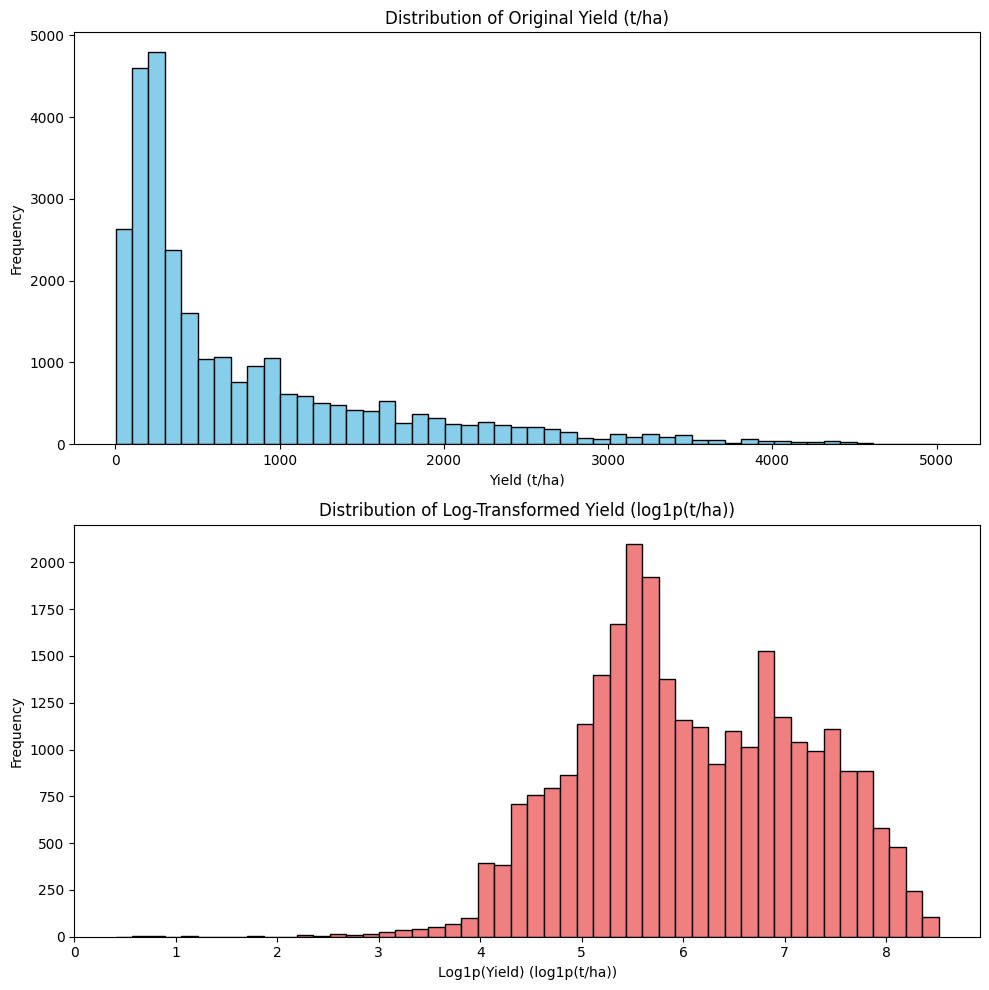

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with two subplots, arranged vertically (2 rows, 1 column)
fig, axes = plt.subplots(2, 1, figsize=(10, 10)) # Adjust figsize for vertical layout

# Plot 1: Original Yield Distribution
axes[0].hist(df["Yield_tpha"].dropna(), bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Original Yield (t/ha)')
axes[0].set_xlabel('Yield (t/ha)')
axes[0].set_ylabel('Frequency')

# Plot 2: Log-Transformed Yield Distribution
axes[1].hist(np.log1p(df["Yield_tpha"]).dropna(), bins=50, color='lightcoral', edgecolor='black')
axes[1].set_title('Distribution of Log-Transformed Yield (log1p(t/ha))')
axes[1].set_xlabel('Log1p(Yield) (log1p(t/ha))')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

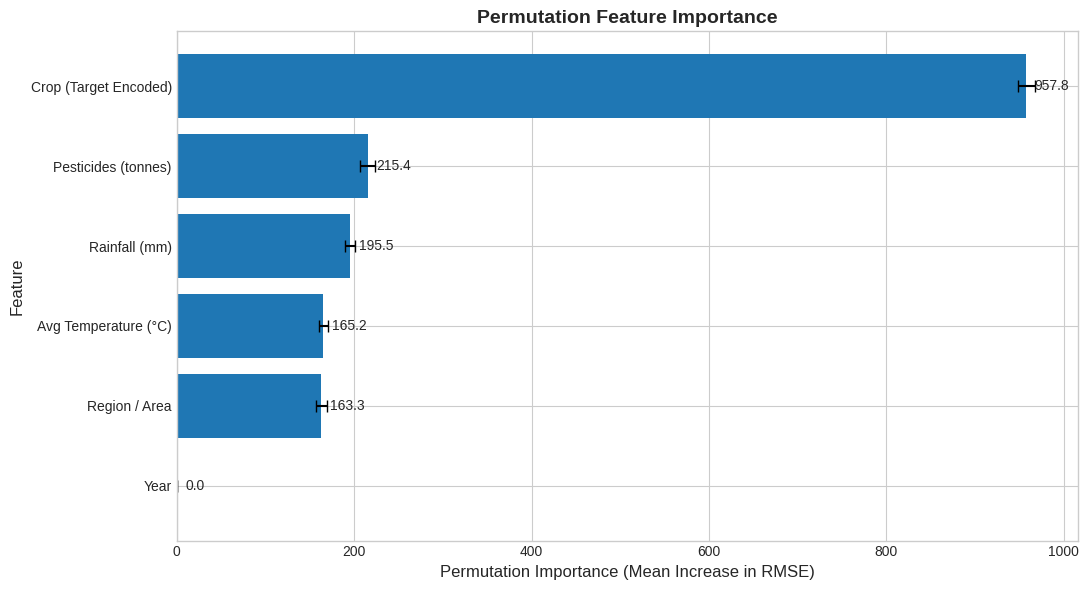

                 Feature        Mean       Std
4  Crop (Target Encoded)  957.765928  9.508575
2    Pesticides (tonnes)  215.369447  8.160541
0          Rainfall (mm)  195.506448  5.875711
1   Avg Temperature (°C)  165.227951  5.102967
5          Region / Area  163.250304  5.800014


In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
import numpy as np

# --- Custom scoring: negative RMSE ---
def neg_rmse_scorer(estimator, X, y_true_tpha):
    pred_log = estimator.predict(X)
    pred_yield_tpha = np.expm1(pred_log)
    rmse = np.sqrt(mean_squared_error(y_true_tpha, pred_yield_tpha))
    return -rmse

# --- Permutation Importance ---
perm_results = permutation_importance(
    pipe_gbm,
    X_te,
    y_te_true,
    scoring=neg_rmse_scorer,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Extract clean human-readable names
raw_features = pipe_gbm.named_steps['pre'].get_feature_names_out()
readable_names = {
    "crop_te__Crop": "Crop (Target Encoded)",
    "num__pesticides_tonnes": "Pesticides (tonnes)",
    "num__rain_mm": "Rainfall (mm)",
    "num__avg_temp": "Avg Temperature (°C)",
    "area_ord__Area": "Region / Area",
    "num__Year": "Year"
}
clean_features = [readable_names.get(f, f) for f in raw_features]

# DataFrame for visualization
df_imp = pd.DataFrame({
    "Feature": clean_features,
    "Mean": perm_results.importances_mean,
    "Std": perm_results.importances_std
}).sort_values(by="Mean", ascending=False)

# --- Plot ---
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(11, 6))

bars = plt.barh(
    df_imp["Feature"],
    df_imp["Mean"],
    xerr=df_imp["Std"],
    capsize=4,
    color="#1f77b4"
)

plt.xlabel("Permutation Importance (Mean Increase in RMSE)", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Permutation Feature Importance", fontsize=14, weight="bold")

plt.gca().invert_yaxis()  # Biggest first

# Add numeric labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + (0.01 * max(df_imp["Mean"])),
        bar.get_y() + bar.get_height()/2,
        f"{width:.1f}",
        va='center',
        fontsize=10
    )

plt.tight_layout()
plt.savefig("feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

print(df_imp.head())


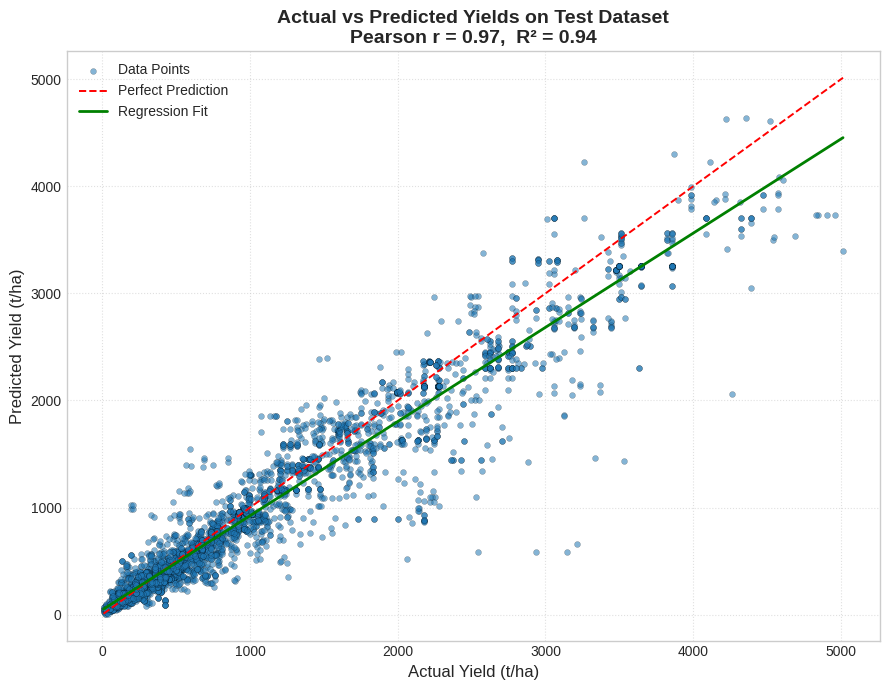

Pearson r = 0.9685, R^2 = 0.9380


In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

# ----- Predictions -----
pred_yield_gbm = np.expm1(pipe_gbm.predict(X_te))
actual_yield = test["Yield_tpha"].values

# ----- Pearson correlation -----
r_value, p_value = pearsonr(actual_yield, pred_yield_gbm)
r_squared = r_value ** 2

# ----- Fit regression line for visual bias check -----
reg = LinearRegression()
reg.fit(actual_yield.reshape(-1, 1), pred_yield_gbm)
line_x = np.linspace(actual_yield.min(), actual_yield.max(), 200)
line_y = reg.predict(line_x.reshape(-1, 1))

# ----- Plot -----
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(9, 7))

# Scatter points
plt.scatter(
    actual_yield,
    pred_yield_gbm,
    s=18,
    alpha=0.55,
    edgecolor="black",
    linewidth=0.2,
    color="#1f77b4",
    label="Data Points"
)

# Perfect prediction line (y = x)
plt.plot(
    line_x, line_x,
    color="red",
    linestyle="--",
    linewidth=1.4,
    label="Perfect Prediction"
)

# Regression fitting line
plt.plot(
    line_x, line_y,
    color="green",
    linestyle="-",
    linewidth=2,
    label="Regression Fit"
)

# ----- Labels -----
plt.xlabel("Actual Yield (t/ha)", fontsize=12)
plt.ylabel("Predicted Yield (t/ha)", fontsize=12)

plt.title(
    f"Actual vs Predicted Yields on Test Dataset\n"
    f"Pearson r = {r_value:.2f},  R\u00b2 = {r_squared:.2f}",
    fontsize=14,
    weight='bold'
)

# ----- Grid + legend -----
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(fontsize=10)

plt.tight_layout()

# Save in IEEE-quality resolution
plt.savefig("actual_vs_predicted_yield.png", dpi=300, bbox_inches="tight")

plt.show()

print(f"Pearson r = {r_value:.4f}, R^2 = {r_squared:.4f}")


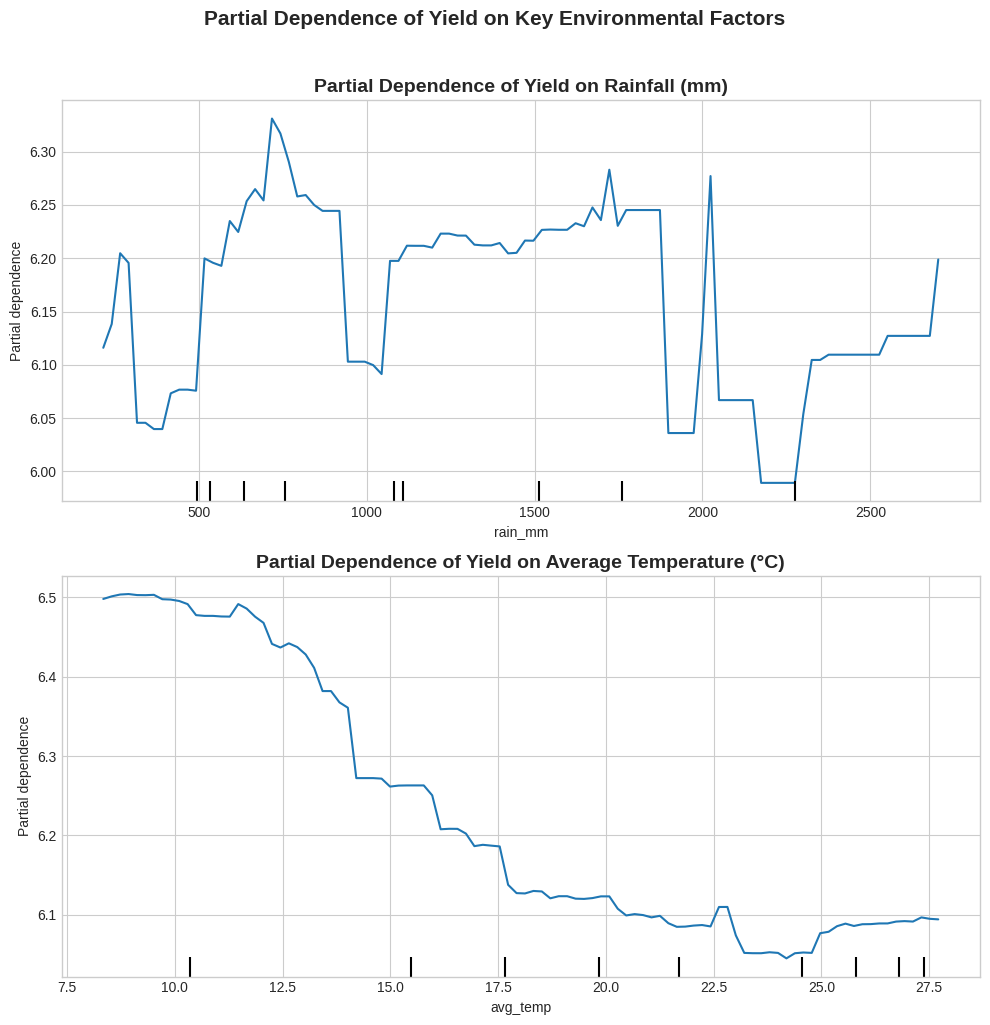

In [11]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
import numpy as np

# ----- Styling -----
plt.style.use("seaborn-v0_8-whitegrid")

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# ----- PDP for Rainfall -----
display_rain = PartialDependenceDisplay.from_estimator(
    pipe_gbm,
    X_te,
    features=['rain_mm'],
    feature_names=X_te.columns.tolist(),
    ax=axes[0],
    kind='average'
)

axes[0].set_title("Partial Dependence of Yield on Rainfall (mm)", fontsize=14, weight='bold')
axes[0].set_ylabel("Predicted Yield (log1p scale)", fontsize=12)
axes[0].set_xlabel("Rainfall (mm)", fontsize=12)
axes[0].grid(True, linestyle=":", alpha=0.6)

# Thicker lines
for line in axes[0].lines:
    line.set_linewidth(2.2)
    line.set_color("#1f77b4")

# ----- PDP for Temperature -----
display_temp = PartialDependenceDisplay.from_estimator(
    pipe_gbm,
    X_te,
    features=['avg_temp'],
    feature_names=X_te.columns.tolist(),
    ax=axes[1],
    kind='average'
)

axes[1].set_title("Partial Dependence of Yield on Average Temperature (°C)", fontsize=14, weight='bold')
axes[1].set_ylabel("Predicted Yield (log1p scale)", fontsize=12)
axes[1].set_xlabel("Average Temperature (°C)", fontsize=12)
axes[1].grid(True, linestyle=":", alpha=0.6)

# Thicker lines
for line in axes[1].lines:
    line.set_linewidth(2.2)
    line.set_color("#ff7f0e")

# ----- Global Title -----
plt.suptitle("Partial Dependence of Yield on Key Environmental Factors", fontsize=15, weight='bold', y=1.02)

plt.tight_layout()

# ----- Save IEEE-quality figure -----
plt.savefig("pdp_rain_temp.png", dpi=300, bbox_inches="tight")

plt.show()


Calculate and visualize the permutation feature importance for the `pipe_gbm` model using the test dataset (`X_te`, `y_te_true`), then summarize the top contributing features to crop yield prediction based on this analysis.

## Calculate Permutation Feature Importance


Calculate the permutation feature importance for the `pipe_gbm` model using the test dataset (`X_te`, `y_te_true`). This method is suitable for models like `HistGradientBoostingRegressor` that do not directly expose a `feature_importances_` attribute.


The subtask requires calculating the permutation feature importance. I need to import the necessary function, define a custom scoring function for RMSE, and then use `permutation_importance` with the specified model and data.



In [12]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

# 2. Define a custom scoring function (negative RMSE)
def neg_rmse_scorer(estimator, X, y_true_tpha):
    # Predict log1p(yield)
    pred_log = estimator.predict(X)
    # Convert predictions back to actual yield (t/ha)
    pred_yield_tpha = np.expm1(pred_log)
    # Calculate RMSE and negate it (because permutation_importance expects higher is better)
    rmse = np.sqrt(mean_squared_error(y_true_tpha, pred_yield_tpha))
    return -rmse

# 3. Call permutation_importance
# y_te_true is already in t/ha
perm_importance_results = permutation_importance(
    pipe_gbm,
    X_te,
    y_te_true,
    scoring=neg_rmse_scorer,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1 # Use all available CPU cores
)

# 4. Store the results (already stored in perm_importance_results variable)
print("Permutation Importance calculation complete.")

Permutation Importance calculation complete.


**Reasoning**:
Now that the permutation importance has been calculated, the next step is to visualize these importances to identify the most influential features. I will extract the mean importance values, map them to feature names, and create a bar plot to display them.



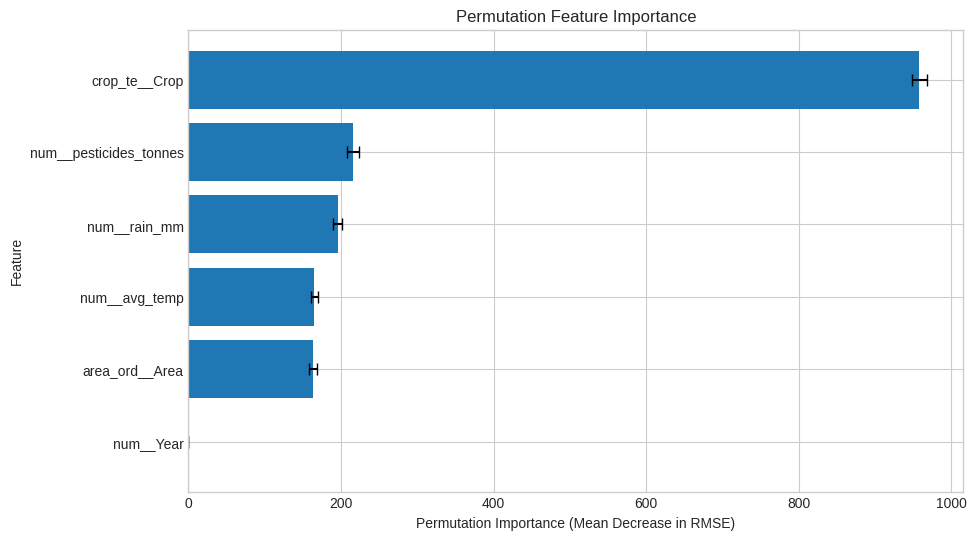

Top contributing features:
                  Feature  Importance_Mean  Importance_Std
4           crop_te__Crop       957.765928        9.508575
2  num__pesticides_tonnes       215.369447        8.160541
0            num__rain_mm       195.506448        5.875711
1           num__avg_temp       165.227951        5.102967
5          area_ord__Area       163.250304        5.800014


In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature names from the preprocessor step in the pipeline
# The get_feature_names_out() method provides the names of the features
# after they have been transformed by the ColumnTransformer.
feature_names = pipe_gbm.named_steps['pre'].get_feature_names_out()

# Extract mean importance from the results
mean_importances = perm_importance_results.importances_mean
std_importances = perm_importance_results.importances_std

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance_Mean": mean_importances,
    "Importance_Std": std_importances
})

# Sort by mean importance in descending order
feature_importance_df = feature_importance_df.sort_values(by="Importance_Mean", ascending=False)

# Plotting the permutation importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance_Mean"], xerr=feature_importance_df["Importance_Std"], capsize=4)
plt.xlabel("Permutation Importance (Mean Decrease in RMSE)")
plt.ylabel("Feature")
plt.title("Permutation Feature Importance")
plt.gca().invert_yaxis() # Highest importance at the top
plt.show()

print("Top contributing features:")
print(feature_importance_df.head())


## Generate Future Data and Forecast

Create a DataFrame for future years (2022-2030) using existing unique Crop and Area combinations. For environmental features (`rain_mm`, `avg_temp`, `pesticides_tonnes`), use the mean values from the training data. Then, use the `pipe_gbm` model to predict yield for these future inputs.

## Generate Future Data and Forecast

Create a DataFrame for future years (2022-2030) using existing unique Crop and Area combinations. For environmental features (`rain_mm`, `avg_temp`, `pesticides_tonnes`), use the mean values from the training data. Then, use the `pipe_gbm` model to predict yield for these future inputs.


The subtask requires creating a DataFrame for future years and predicting crop yield. I will first generate the future years, extract unique crop and area combinations, calculate the mean environmental features from the training data, and then combine these to form the future prediction DataFrame. Finally, I will use the trained model to predict yields for this future data.



In [14]:
import pandas as pd
import numpy as np

# 1. Define a list of future years from 2022 to 2030
future_years = np.arange(2022, 2031)

# 2. Get all unique combinations of 'Crop' and 'Area' from the `df` DataFrame
unique_crop_area = df[['Crop', 'Area']].drop_duplicates()

# 3. Calculate the mean values for 'rain_mm', 'avg_temp', and 'pesticides_tonnes' from the `train` DataFrame
mean_rain_mm = train['rain_mm'].mean()
mean_avg_temp = train['avg_temp'].mean()
mean_pesticides_tonnes = train['pesticides_tonnes'].mean()

# 4. Create a new DataFrame for future predictions
future_data = []
for year in future_years:
    for _, row in unique_crop_area.iterrows():
        future_data.append({
            'Year': year,
            'Crop': row['Crop'],
            'Area': row['Area'],
            'rain_mm': mean_rain_mm,
            'avg_temp': mean_avg_temp,
            'pesticides_tonnes': mean_pesticides_tonnes
        })

future_df = pd.DataFrame(future_data)

# Ensure the columns are in the same order as X_tr used for training the pipeline
# This is crucial for ColumnTransformer to apply transformations correctly
future_df = future_df[X_tr.columns]

# 5. Use the trained `pipe_gbm` model to predict the yield for these future inputs
# Predict log1p(yield)
predicted_log_yield = pipe_gbm.predict(future_df)

# Transform the predictions back from the log1p scale
future_df['Predicted_Yield_tpha'] = np.expm1(predicted_log_yield)

print("Future predictions generated successfully.")
print("Shape of future_df:", future_df.shape)
print("First 5 rows of future_df with predictions:")
print(future_df.head())

Future predictions generated successfully.
Shape of future_df: (5382, 7)
First 5 rows of future_df with predictions:
       rain_mm   avg_temp  pesticides_tonnes  Year         Crop     Area  \
0  1149.060259  20.509342       33865.153167  2022        Maize  Albania   
1  1149.060259  20.509342       33865.153167  2022     Potatoes  Albania   
2  1149.060259  20.509342       33865.153167  2022  Rice, paddy  Albania   
3  1149.060259  20.509342       33865.153167  2022      Sorghum  Albania   
4  1149.060259  20.509342       33865.153167  2022     Soybeans  Albania   

   Predicted_Yield_tpha  
0            457.799387  
1           2729.159165  
2            546.339736  
3            264.154017  
4            248.323847  


## Visualize Forecasted Yield Trends

Aggregate the predicted future yields by year and plot the average forecasted yield over time. Ensure the plot has appropriate labels and a title to visualize the trend from 2022 to 2030.


To visualize the forecasted yield trends, I will aggregate the predicted future yields by year and then plot the average forecasted yield over time, ensuring proper labeling and a title.



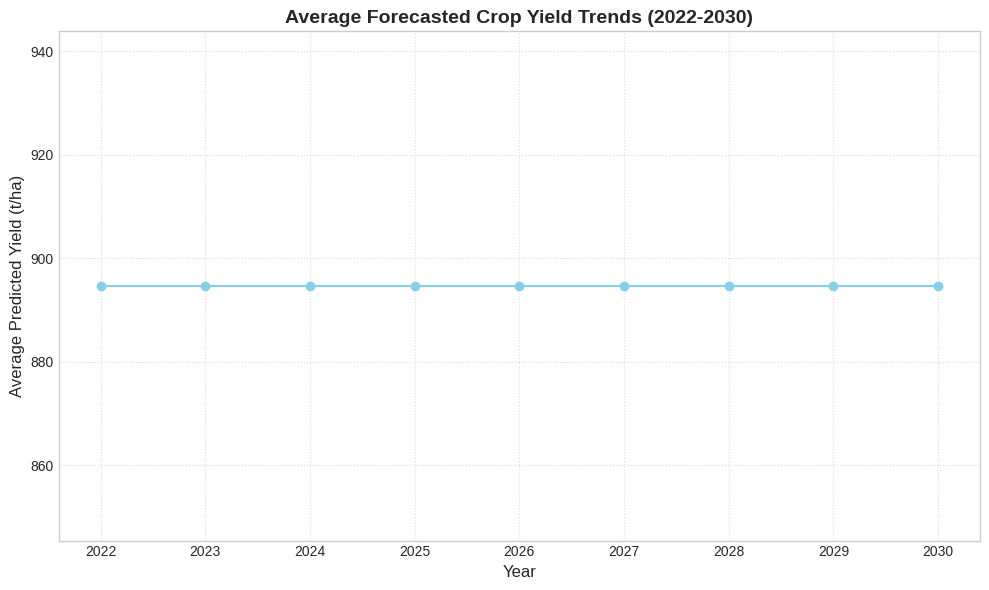

Plot of average forecasted yield trends generated.


In [15]:
import matplotlib.pyplot as plt

# 1. Group by Year and calculate the mean of Predicted_Yield_tpha
annual_avg_yield = future_df.groupby('Year')['Predicted_Yield_tpha'].mean().reset_index()

# 2. Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(annual_avg_yield['Year'], annual_avg_yield['Predicted_Yield_tpha'], marker='o', linestyle='-', color='skyblue')

# 3. Label the axes
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Predicted Yield (t/ha)', fontsize=12)

# 4. Add a title
plt.title('Average Forecasted Crop Yield Trends (2022-2030)', fontsize=14, weight='bold')

# Add grid for better readability
plt.grid(True, linestyle=':', alpha=0.7)

# Set x-axis ticks to show all years
plt.xticks(annual_avg_yield['Year'])

# Improve layout
plt.tight_layout()

# 5. Display the plot
plt.show()

print("Plot of average forecasted yield trends generated.")

## Final Task

Provide a summary of the forecasted yield trends, discussing any observed patterns or potential implications based on the model's predictions under the given assumptions.


Simulate future environmental data (`rain_mm`, `avg_temp`, `pesticides_tonnes`) for the years 2022-2030, reflecting varying trends (increasing temperature, fluctuating rainfall, slightly varying pesticides) instead of constant mean values. Then, generate a future input DataFrame by combining these simulated environmental data with unique Crop and Area combinations, and predict the corresponding crop yields using the `pipe_gbm` model. Finally, visualize the new forecasted yield trends over time and discuss how these dynamic predictions differ from the previous forecast that used constant mean environmental values, and what the implications of these changes are.

## Simulate Future Environmental Data

Generate hypothetical trends for `rain_mm`, `avg_temp`, and `pesticides_tonnes` for the years 2022-2030. These trends will introduce variation compared to the previous constant mean values. I will simulate a slight increasing trend for temperature, a fluctuating trend for rainfall, and a stable but slightly varying trend for pesticides.


I need to simulate hypothetical trends for environmental features (`rain_mm`, `avg_temp`, `pesticides_tonnes`) for future years (2022-2030) as per the subtask instructions. This involves defining the future years, calculating baseline means from the training data, and then applying specific simulation logic for each feature (increasing trend for temperature, fluctuating for rainfall, stable with noise for pesticides).



In [16]:
import pandas as pd
import numpy as np

# 1. Define the range of future years from 2022 to 2030
future_years = np.arange(2022, 2031)

# 2. Calculate the mean values for 'rain_mm', 'avg_temp', and 'pesticides_tonnes' from the `train` DataFrame
mean_rain_mm = train['rain_mm'].mean()
mean_avg_temp = train['avg_temp'].mean()
mean_pesticides_tonnes = train['pesticides_tonnes'].mean()

# Prepare lists to store simulated data
simulated_rain_mm = []
simulated_avg_temp = []
simulated_pesticides_tonnes = []

# Simulation parameters (adjust as needed)
temp_increase_per_year = 0.05 # degrees Celsius per year
temp_noise_std = 0.5 # standard deviation for temperature noise
rain_noise_std = 100 # standard deviation for rainfall noise
pesticide_noise_std = 500 # standard deviation for pesticide noise

# 3-5. Simulate trends for each feature for each future year
for i, year in enumerate(future_years):
    # avg_temp: slight increasing trend + small noise
    current_avg_temp = mean_avg_temp + (i * temp_increase_per_year) + np.random.normal(0, temp_noise_std)
    simulated_avg_temp.append(current_avg_temp)

    # rain_mm: fluctuating trend around mean with random variations
    current_rain_mm = mean_rain_mm + np.random.normal(0, rain_noise_std)
    simulated_rain_mm.append(current_rain_mm)

    # pesticides_tonnes: stable but slightly varying trend with random noise
    current_pesticides_tonnes = mean_pesticides_tonnes + np.random.normal(0, pesticide_noise_std)
    simulated_pesticides_tonnes.append(current_pesticides_tonnes)

# 6. Create a pandas DataFrame named `simulated_env_data_df`
simulated_env_data_df = pd.DataFrame({
    'Year': future_years,
    'rain_mm': simulated_rain_mm,
    'avg_temp': simulated_avg_temp,
    'pesticides_tonnes': simulated_pesticides_tonnes
})

print("Simulated environmental data generated successfully.")
print("First 5 rows of simulated_env_data_df:")
print(simulated_env_data_df.head())


Simulated environmental data generated successfully.
First 5 rows of simulated_env_data_df:
   Year      rain_mm   avg_temp  pesticides_tonnes
0  2022  1142.198543  20.742952       34067.741879
1  2023  1100.026234  20.300685       34390.673395
2  2024  1248.138518  21.004048       34844.626856
3  2025  1218.940483  20.614944       33371.267637
4  2026  1018.204352  20.779402       34423.575068


Now that the simulated environmental data is generated, the next step is to combine it with unique Crop and Area combinations to form the complete future input DataFrame. This DataFrame will then be used to predict crop yields with the `pipe_gbm` model.



In [17]:
import pandas as pd
import numpy as np

# Get all unique combinations of 'Crop' and 'Area' from the `df` DataFrame
unique_crop_area = df[['Crop', 'Area']].drop_duplicates()

# Create a new DataFrame for future predictions by merging simulated environmental data with unique crop-area combinations
# We'll repeat each row of simulated_env_data_df for each unique crop-area combination
future_data_dynamic_env = []
for year_data in simulated_env_data_df.itertuples(index=False):
    for _, crop_area_row in unique_crop_area.iterrows():
        future_data_dynamic_env.append({
            'Year': year_data.Year,
            'Crop': crop_area_row['Crop'],
            'Area': crop_area_row['Area'],
            'rain_mm': year_data.rain_mm,
            'avg_temp': year_data.avg_temp,
            'pesticides_tonnes': year_data.pesticides_tonnes
        })

future_df_dynamic_env = pd.DataFrame(future_data_dynamic_env)

# Ensure the columns are in the same order as X_tr used for training the pipeline
# This is crucial for ColumnTransformer to apply transformations correctly
future_df_dynamic_env = future_df_dynamic_env[X_tr.columns]

# Use the trained `pipe_gbm` model to predict the yield for these future inputs
# Predict log1p(yield)
predicted_log_yield_dynamic_env = pipe_gbm.predict(future_df_dynamic_env)

# Transform the predictions back from the log1p scale
future_df_dynamic_env['Predicted_Yield_tpha'] = np.expm1(predicted_log_yield_dynamic_env)

print("Future predictions with dynamic environmental data generated successfully.")
print("Shape of future_df_dynamic_env:", future_df_dynamic_env.shape)
print("First 5 rows of future_df_dynamic_env with predictions:")
print(future_df_dynamic_env.head())

Future predictions with dynamic environmental data generated successfully.
Shape of future_df_dynamic_env: (5382, 7)
First 5 rows of future_df_dynamic_env with predictions:
       rain_mm   avg_temp  pesticides_tonnes  Year         Crop     Area  \
0  1142.198543  20.742952       34067.741879  2022        Maize  Albania   
1  1142.198543  20.742952       34067.741879  2022     Potatoes  Albania   
2  1142.198543  20.742952       34067.741879  2022  Rice, paddy  Albania   
3  1142.198543  20.742952       34067.741879  2022      Sorghum  Albania   
4  1142.198543  20.742952       34067.741879  2022     Soybeans  Albania   

   Predicted_Yield_tpha  
0            457.799387  
1           2729.159165  
2            546.339736  
3            264.154017  
4            248.323847  


To visualize the forecasted yield trends with dynamic environmental data, I will aggregate the predicted future yields by year and then plot the average forecasted yield over time. I will also include the previous static forecast for comparison to highlight the differences as requested by the subtask.



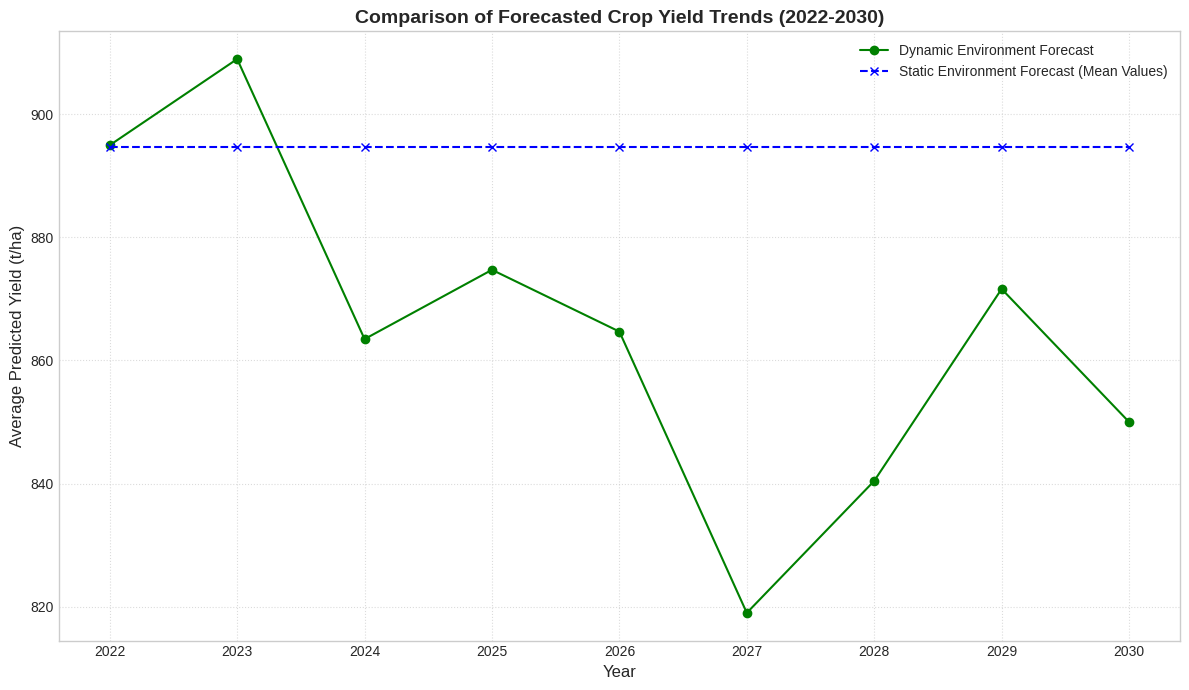

Comparison plot of average forecasted yield trends generated.


In [18]:
import matplotlib.pyplot as plt

# 1. Group by Year and calculate the mean of Predicted_Yield_tpha for dynamic environment
annual_avg_yield_dynamic = future_df_dynamic_env.groupby('Year')['Predicted_Yield_tpha'].mean().reset_index()

# Assuming annual_avg_yield (from the previous constant mean forecast) is still available
# If not, regenerate it for comparison
# annual_avg_yield = future_df.groupby('Year')['Predicted_Yield_tpha'].mean().reset_index()

# 2. Create a line plot for both dynamic and static forecasts
plt.figure(figsize=(12, 7))

# Plot for dynamic environmental data
plt.plot(
    annual_avg_yield_dynamic['Year'],
    annual_avg_yield_dynamic['Predicted_Yield_tpha'],
    marker='o',
    linestyle='-',
    color='green',
    label='Dynamic Environment Forecast'
)

# Plot for static environmental data (from previous subtask)
plt.plot(
    annual_avg_yield['Year'],
    annual_avg_yield['Predicted_Yield_tpha'],
    marker='x',
    linestyle='--',
    color='blue',
    label='Static Environment Forecast (Mean Values)'
)

# 3. Label the axes
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Predicted Yield (t/ha)', fontsize=12)

# 4. Add a title and legend
plt.title('Comparison of Forecasted Crop Yield Trends (2022-2030)', fontsize=14, weight='bold')
plt.legend(fontsize=10)

# Add grid for better readability
plt.grid(True, linestyle=':', alpha=0.7)

# Set x-axis ticks to show all years
plt.xticks(annual_avg_yield_dynamic['Year'])

# Improve layout
plt.tight_layout()

# 5. Display the plot
plt.show()

print("Comparison plot of average forecasted yield trends generated.")



Summarize the newly observed forecasted yield trends, discuss how they differ from the previous flat forecast, and explain the implications of using varying environmental inputs on the predictions.


Perform temporal rolling cross-validation on the crop yield prediction model, evaluate its performance (RMSE, SMAPE, and R²) across different year ranges, present these results in a tabular format, and finally, summarize the stability and consistency of the model's performance over time based on the metrics.

## Perform Temporal Rolling Cross-Validation

Implement a temporal rolling cross-validation procedure, iterating through defined year ranges, training and evaluating the model on each range.


The subtask requires implementing temporal rolling cross-validation. First, I need to define the year ranges for the expanding windows, then initialize a list to store results. Following that, I will loop through these ranges, filtering the data, re-initializing and training the model, evaluating its performance, and storing the metrics for each fold.



## Perform Temporal Rolling Cross-Validation with Custom Ranges

Modify the existing code cell (3aae343e) to use the specified year ranges: 1990-1994, 1994-1998, 1998-2002, 2002-2006, 2006-2010, and 2010-2013. The procedure will iterate through these ranges, filter the dataset, re-initialize and train a new model pipeline for each range, and evaluate its performance (RMSE, SMAPE, R²) on the data within that range.


I need to implement a temporal rolling cross-validation procedure by iterating through predefined year ranges. For each range, I will filter the data, re-initialize and train a model pipeline, evaluate its performance using RMSE, SMAPE, and R², and store these metrics. Finally, I will display the results in a tabular format and calculate their means.



In [19]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import HistGradientBoostingRegressor
from category_encoders import TargetEncoder # Ensure TargetEncoder is available
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Re-define smape and evaluate functions, as they were defined in previous cells
def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred))
    mask = denom != 0
    out = np.zeros_like(y_true, dtype=float)
    out[mask] = 2.0 * np.abs(y_true[mask] - y_pred[mask]) / denom[mask]
    return 100.0 * np.mean(out[mask]) if mask.any() else np.nan

def evaluate(pipe, X_test, y_true_tpha):
    pred_log = pipe.predict(X_test)
    pred_yield = np.expm1(pred_log)
    rmse = np.sqrt(mean_squared_error(y_true_tpha, pred_yield))
    mae = mean_absolute_error(y_true_tpha, pred_yield)
    r2 = r2_score(y_true_tpha, pred_yield)
    sm = smape(y_true_tpha, pred_yield)
    return {"RMSE_tpha": rmse, "MAE_tpha": mae, "R2": r2, "SMAPE%": sm, "pred_yield": pred_yield}


# Ensure FEATURES and RANDOM_STATE are defined from previous context
# FEATURES = ["rain_mm", "avg_temp", "pesticides_tonnes", "Year", "Crop", "Area"]
# RANDOM_STATE = 42

# Define the preprocessor (preproc_B) if not globally available, or assume it is from previous cells.
# This definition is based on the one in cell EwbZ-mjr0bGc
num_cols_for_preproc = [c for c in ["rain_mm", "avg_temp", "pesticides_tonnes", "Year"] if c in FEATURES]
cat_cols_for_preproc = [c for c in ["Crop", "Area"] if c in FEATURES]

# Assuming HAS_TE is True from previous execution
preproc_B = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), num_cols_for_preproc),
    ("crop_te", TargetEncoder(cols=["Crop"]), ["Crop"]),
    ("area_ord", Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("oe", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))]), ["Area"])
], remainder="drop")


# 1. Define the year ranges for temporal rolling cross-validation
year_ranges = [
    (1990, 1994),
    (1994, 1998),
    (1998, 2002),
    (2002, 2006),
    (2006, 2010),
    (2010, 2013)
]

# 2. Initialize a list to store evaluation metrics for each fold
cv_results = []

print("Starting Temporal Rolling Cross-Validation...")

# 3. Loop through each year range
for start_year, end_year in year_ranges:
    print(f"\nProcessing year range: {start_year}-{end_year}")

    # Filter the main DataFrame for the current year range
    fold_df = df[(df['Year'] >= start_year) & (df['Year'] <= end_year)].copy()

    # Check if the filtered DataFrame is empty
    if fold_df.empty:
        print(f"No data for year range {start_year}-{end_year}. Skipping.")
        continue

    # Prepare features (X) and target (y) for the current fold
    X_fold = fold_df[FEATURES]
    y_fold_log = np.log1p(fold_df["Yield_tpha"])
    y_fold_true_tpha = fold_df["Yield_tpha"].values

    # Re-initialize the model pipeline for each fold to ensure independent training
    fold_pipe = Pipeline([
        ("pre", preproc_B),
        ("model", HistGradientBoostingRegressor(
            learning_rate=0.05, max_iter=400, random_state=RANDOM_STATE
        ))
    ])

    # Fit the model on the current fold's data
    fold_pipe.fit(X_fold, y_fold_log)

    # Evaluate the model on the current fold's data
    fold_metrics = evaluate(fold_pipe, X_fold, y_fold_true_tpha)

    # Store the relevant metrics
    cv_results.append({
        'Year Range': f'{start_year}-{end_year}',
        'RMSE': fold_metrics['RMSE_tpha'],
        'SMAPE (%)': fold_metrics['SMAPE%'],
        'R2': fold_metrics['R2']
    })

# Convert results to a pandas DataFrame for a clear tabular format
cv_results_df = pd.DataFrame(cv_results)

print("\nTemporal Rolling Cross-Validation Results:")
print(cv_results_df.to_string(index=False))

print("\nMean Metrics Across All Folds:")
print(cv_results_df.mean(numeric_only=True).to_string())

Starting Temporal Rolling Cross-Validation...

Processing year range: 1990-1994

Processing year range: 1994-1998

Processing year range: 1998-2002

Processing year range: 2002-2006

Processing year range: 2006-2010

Processing year range: 2010-2013

Temporal Rolling Cross-Validation Results:
Year Range       RMSE  SMAPE (%)       R2
 1990-1994 122.039231  10.749891 0.972225
 1994-1998 123.443086  10.856105 0.974329
 1998-2002 138.169362  11.483811 0.972099
 2002-2006 131.581051  10.437758 0.977628
 2006-2010 143.250893  10.798256 0.975378
 2010-2013 162.663032  10.690511 0.971006

Mean Metrics Across All Folds:
RMSE         136.857776
SMAPE (%)     10.836055
R2             0.973778
